### load library

In [99]:
import numpy as np # linear algebra
import pandas as pd # data processing

In [100]:
from tensorflow import keras

import matplotlib.pyplot as plt

### Load dataset 

In [101]:
train_data_path = '../input/emnist-balanced-train.csv'
test_data_path = '../input/emnist-balanced-test.csv'

In [102]:
train_data = pd.read_csv(train_data_path, header=None)

In [103]:
#train_data.head(10)

In [104]:
# The classes of this balanced dataset are as follows. Index into it based on class label
class_mapping = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'

In [105]:
#class_mapping[0]

In [106]:
train_data.shape

(112800, 785)

## Data is flipped

In [107]:
num_classes = len(train_data[0].unique())
row_num = 8

#plt.imshow(train_data.values[row_num, 1:].reshape([28, 28]), cmap='Greys_r')
#plt.show()

img_flip = np.transpose(train_data.values[row_num,1:].reshape(28, 28), axes=[1,0]) # img_size * img_size arrays
#plt.imshow(img_flip, cmap='Greys_r')

#plt.show()

In [108]:
def show_img(data, row_num):
    img_flip = np.transpose(data.values[row_num,1:].reshape(28, 28), axes=[1,0]) # img_size * img_size arrays
    plt.title('Class: ' + str(data.values[row_num,0]) + ', Label: ' + str(class_mapping[data.values[row_num,0]]))
    plt.imshow(img_flip, cmap='Greys_r')

In [109]:
#show_img(train_data, 149)

In [110]:
num_classes = 47 
img_size = 28

def img_label_load(data_path, num_classes=None):
    data = pd.read_csv(data_path, header=None)
    data_rows = len(data)
    if not num_classes:
        num_classes = len(data[0].unique())
    
    # this assumes square imgs. Should be 28x28
    img_size = int(np.sqrt(len(data.iloc[0][1:])))
    
    # Images need to be transposed. This line also does the reshaping needed.
    imgs = np.transpose(data.values[:,1:].reshape(data_rows, img_size, img_size, 1), axes=[0,2,1,3]) # img_size * img_size arrays
    
    labels = keras.utils.to_categorical(data.values[:,0], num_classes) # one-hot encoding vectors
    
    return imgs/255., labels



### model, compile

In [111]:
model = keras.models.Sequential()

# model.add(keras.layers.Reshape((img_size,img_size,1), input_shape=(784,)))
model.add(keras.layers.Conv2D(filters=12, kernel_size=(5,5), strides=2, activation='relu', 
                              input_shape=(img_size,img_size,1)))
# model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(.5))

model.add(keras.layers.Conv2D(filters=18, kernel_size=(3,3) , strides=2, activation='relu'))
# model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(.5))

model.add(keras.layers.Conv2D(filters=24, kernel_size=(2,2), activation='relu'))
# model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

# model.add(keras.layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=150, activation='relu'))
model.add(keras.layers.Dense(units=num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 12, 12, 12)        312       
_________________________________________________________________
dropout_8 (Dropout)          (None, 12, 12, 12)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 5, 5, 18)          1962      
_________________________________________________________________
dropout_9 (Dropout)          (None, 5, 5, 18)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 24)          1752      
_________________________________________________________________
flatten_4 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 150)               57750     
__________

In [112]:
for layer in model.layers:
    print(layer.get_output_at(0).get_shape().as_list())


[None, 12, 12, 12]
[None, 12, 12, 12]
[None, 5, 5, 18]
[None, 5, 5, 18]
[None, 4, 4, 24]
[None, 384]
[None, 150]
[None, 47]


### Train

In [113]:
X, y = img_label_load(train_data_path)
print(X.shape)

(112800, 28, 28, 1)


In [114]:
data_generator = keras.preprocessing.image.ImageDataGenerator(validation_split=.2)
## consider using this for more variety
data_generator_with_aug = keras.preprocessing.image.ImageDataGenerator(validation_split=.2,
                                            width_shift_range=.2, height_shift_range=.2,
                                            rotation_range=60, zoom_range=.2, shear_range=.3)

# if already ran this above, no need to do it again
# X, y = img_label_load(train_data_path)
# print("X.shape: ", X.shape)

training_data_generator = data_generator.flow(X, y, subset='training')
validation_data_generator = data_generator.flow(X, y, subset='validation')
history = model.fit_generator(training_data_generator, 
                              steps_per_epoch=500, epochs=5, # can change epochs to 10
                              validation_data=validation_data_generator)


Epoch 1/5
500/500 [==============================] - 9s 17ms/step - loss: 2.4917 - acc: 0.3239 - val_loss: 1.4343 - val_acc: 0.5876
Epoch 2/5
500/500 [==============================] - 7s 15ms/step - loss: 1.4826 - acc: 0.5586 - val_loss: 1.0361 - val_acc: 0.6941
Epoch 3/5
500/500 [==============================] - 7s 15ms/step - loss: 1.1890 - acc: 0.6366 - val_loss: 0.8857 - val_acc: 0.7244
Epoch 4/5
500/500 [==============================] - 8s 16ms/step - loss: 1.0390 - acc: 0.6773 - val_loss: 0.7914 - val_acc: 0.7498
Epoch 5/5
500/500 [==============================] - 7s 15ms/step - loss: 0.9503 - acc: 0.7027 - val_loss: 0.7293 - val_acc: 0.7695


In [115]:
test_X, test_y = img_label_load(test_data_path)
test_data_generator = data_generator.flow(X, y)

model.evaluate_generator(test_data_generator)

[0.7078051537740315, 0.7731471631205674]

## Look at some predictions


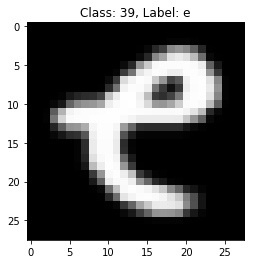

In [116]:
test_data = pd.read_csv(test_data_path, header=None)
show_img(test_data, 129)

In [117]:
X_test, y_test = img_label_load(test_data_path) # loads images and orients for model

In [118]:
def run_prediction(idx):
    result = np.argmax(model.predict(X_test[idx:idx+1]))
    print('Prediction: ', result, ', Char: ', class_mapping[result])
    print('Label: ', test_data.values[idx,0])
    show_img(test_data, idx)

Prediction:  39 , Char:  e
Label:  39
Prediction:  15 , Char:  F
Label:  40
Prediction:  43 , Char:  n
Label:  43
Prediction:  39 , Char:  e
Label:  39
Prediction:  16 , Char:  G
Label:  16
Prediction:  39 , Char:  e
Label:  39
Prediction:  5 , Char:  5
Label:  5
Prediction:  12 , Char:  C
Label:  12
Prediction:  12 , Char:  C
Label:  12


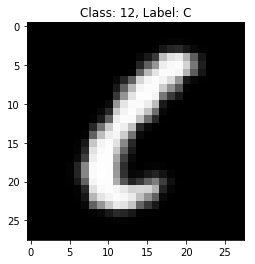

In [119]:
import random

for _ in range(1,10):
    idx = random.randint(0, 47-1)
    run_prediction(idx)

In [120]:
#show_img(test_data, 123)
#np.argmax(y_test[123])

In [121]:
# First, convert Keras Model to TensorFlow Estimator
model_input_name = model.input_names[0]
estimator_model = keras.estimator.model_to_estimator(keras_model=model, model_dir="./estimator_model")
print(model_input_name)

conv2d_12_input


In [122]:
# Next, export the TensorFlow Estimator to SavedModel

from functools import partial
import tensorflow as tf

def serving_input_receiver_fn():
    input_ph = tf.placeholder(tf.string, shape=[None], name='image_binary')
    images = tf.map_fn(partial(tf.image.decode_image, channels=1), input_ph, dtype=tf.uint8)
    images = tf.cast(images, tf.float32) / 255.
    images.set_shape([None, 28, 28, 1])

    # the first key is the name of first layer of the (keras) model. 
    # The second key is the name of the key that will be passed in the prediction request
    return tf.estimator.export.ServingInputReceiver({model_input_name: images}, {'bytes': input_ph})

In [123]:
with open('model.json', 'w') as f:
    f.write(model.to_json())
model.save_weights('./model.h5')

model.save('./full_model.h5')
!ls -lh

total 1.2M
---------- 1 root root  263 Oct  3 13:01 __notebook_source__.ipynb
-rw-r--r-- 1 root root  643 Oct  3 13:30 class_19_label_J.json
-rw-r--r-- 1 root root  458 Oct  3 13:30 class_19_label_J.png
drwxr-xr-x 2 root root 4.0K Oct  3 13:15 estimator_model
drwxr-xr-x 5 root root 4.0K Oct  3 13:28 export
-rw-r--r-- 1 root root 847K Oct  3 13:33 full_model.h5
-rw-r--r-- 1 root root 293K Oct  3 13:33 model.h5
-rw-r--r-- 1 root root 3.5K Oct  3 13:33 model.json
